In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib.imports import *
from lib.utils import *
from lib.functions import *

In [3]:
device = 'cpu'
ckpt = 'edge_pred_2.pt'

In [4]:
class EdgePredictor(nn.Module):
    def __init__(self, num_blocks=3):
        super().__init__()
        
        self.in_blocks = nn.ModuleList([
            GNNBlockForEdgePrediction(feat_dims=[2, 8], bn=True, dp=0.2, n_edge_attr=2)
        ])
        self.hid_blocks = nn.ModuleList([
            GNNBlockForEdgePrediction(feat_dims=[8, 16, 16, 8], 
                     efeat_hid_dims=[16],
                     bn=True, 
                     act=True,
                     dp=0.2, 
                     n_edge_attr=2,
                     residual=True)
            for _ in range(num_blocks)
        ])
        self.out_blocks = nn.ModuleList([
            GNNBlockForEdgePrediction(feat_dims=[8, 8], act=False, n_edge_attr=2)
        ])

    def forward(self, data):
        x = data.pos
        e = data.edge_index
        label = data.y
        for block in chain(self.in_blocks, 
                           self.hid_blocks, 
                           self.out_blocks):
            x = block(x, data)
        prob = F.cosine_similarity(x[e[0]], x[e[1]]).add(1).div(2)
        pos = label.eq(1)
        neg = label.eq(0)
        pos_w = neg.sum().float().div(len(label))
        neg_w = pos.sum().float().div(len(label))
        w = pos * pos_w + neg * neg_w
        loss = (prob - label).square().mul(w).mean()
        return loss, prob

In [5]:
def rescale_with_normalized_density(pos):
    pos = (pos.sub(pos.mean(dim=0))
              .div(pos.std(dim=0).mean())
              .mul(np.sqrt(pos.size()[0])))
    return pos

In [6]:
def generate_data(G):
    i, j = np.meshgrid(*([np.arange(G.number_of_nodes())] * 2))
    pos = np.array(list(nx.nx_agraph.graphviz_layout(G, prog='neato').values()))
    node_pos = rescale_with_normalized_density(torch.tensor(pos, dtype=torch.float32).to(device))
    edge_feat = torch.tensor(pos[j] - pos[i], dtype=torch.float32).to(device)
    edge_label = torch.tensor(nx.to_numpy_matrix(G), dtype=torch.float32).to(device)
    return nx_to_tg(G=G, 
                    pos=node_pos,
                    edge_feat=edge_feat,
                    edge_label=edge_label)

In [ ]:
datafiles = glob.glob("data/rome/*.graphml") 
G_list = [nx.read_graphml(datafile) for datafile in tqdm(datafiles)] 
data_list = [generate_data(G) for G in tqdm(G_list)]
torch.save(data_list, open('data_list_datagen.pickle', 'wb'))
torch.save(G_list, open('G_list_datagen.pickle', 'wb'))

In [7]:
data_list = torch.load(open('data_list_datagen.pickle', 'rb'), map_location=torch.device(device))
G_list = torch.load(open('G_list_datagen.pickle', 'rb'), map_location=torch.device(device))

In [6]:
loader = DataLoader(data_list, batch_size=128, shuffle=True)

In [8]:
state_dict = torch.load(open(ckpt, "rb"), map_location=torch.device(device))
model = EdgePredictor().to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [41]:
model = EdgePredictor().to(device)

In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [10]:
real_epoch = 0

In [61]:
for epoch in range(9999):
    real_epoch += 1
    model.train()
    loss_all, acc_all, prec_all, rec_all, f1_all = [], [], [], [], []
    for itr, batch in enumerate(tqdm(loader)):
        batch = batch.to(device)
        optimizer.zero_grad()
        loss, prob = model(batch)
        loss.backward()
        optimizer.step()
        pred = (prob > 0.5).long()
        label = batch.y
        accuracy = metrics.accuracy_score(label.detach().cpu(), pred.detach().cpu())
        precision = metrics.precision_score(label.detach().cpu(), pred.detach().cpu())
        recall = metrics.recall_score(label.detach().cpu(), pred.detach().cpu())
        f1 = metrics.f1_score(label.detach().cpu(), pred.detach().cpu())
        loss_all += [loss.item()]
        acc_all += [accuracy]
        prec_all += [precision]
        rec_all += [recall]
        f1_all += [f1]
        if itr % 1 == 0:
            print(f'loss: {loss.item():.4f}, accuracy: {accuracy:.2f}, precision: {precision:.2f}, recall: {recall:.2f}, f1: {f1:.2f}')
#             p, r, t = metrics.precision_recall_curve(label.cpu().numpy(), logits.detach().cpu().numpy())
#             plt.plot(p, r, 'o-')
#             plt.show()
    print(f'[{real_epoch}] loss: {np.mean(loss_all):.4f}, accuracy: {np.mean(acc_all):.2f}, precision: {np.mean(prec_all):.2f}, recall: {np.mean(rec_all):.2f}, f1: {np.mean(f1_all):.2f}', file=open('edge_pred.log', 'a'))
    torch.save(model.state_dict(), open(ckpt, 'wb'))
    scheduler.step()

loss: 0.2473, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.21
loss: 0.2453, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2447, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2468, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2477, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2465, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2460, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2473, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2445, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2458, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2468, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2473, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2454, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2459, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2483, accura

loss: 0.2467, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2469, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2448, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2463, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2473, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2462, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2450, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2439, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2465, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.21
loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2460, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2427, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.23
loss: 0.2479, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2471, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2470, accura

loss: 0.2454, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2474, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2471, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2457, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2436, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2470, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.21
loss: 0.2472, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2459, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2457, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2457, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2447, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2472, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2459, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2475, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2473, accura

loss: 0.2475, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2478, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2474, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2446, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2466, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2463, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2443, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2482, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.19
loss: 0.2476, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2459, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2463, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2471, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2466, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2428, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.23
loss: 0.2464, accura

loss: 0.2476, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2434, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.23
loss: 0.2459, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2449, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2455, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2449, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2454, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2447, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2439, accuracy: 0.70, precision: 0.13, recall: 0.98, f1: 0.22
loss: 0.2439, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2478, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2458, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2469, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.21
loss: 0.2455, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2461, accura

loss: 0.2452, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2465, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2448, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2435, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2444, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2451, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2457, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2476, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2466, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2471, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2454, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2449, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2450, accura

loss: 0.2460, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2457, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2460, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2445, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2450, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2458, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2475, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2448, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2452, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2443, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2443, accuracy: 0.70, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2475, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2460, accura

loss: 0.2455, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2454, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2459, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2467, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2438, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2455, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2452, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2454, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2443, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2460, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2452, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2470, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2462, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2473, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2450, accura

loss: 0.2475, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2456, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2464, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2446, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2465, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2423, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.23
loss: 0.2458, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2476, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2450, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2462, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2456, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2453, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2467, accura

loss: 0.2475, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2465, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.21
loss: 0.2470, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2467, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2460, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2467, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2449, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2458, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2433, accuracy: 0.69, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2468, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2470, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2453, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2448, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2451, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2454, accura

loss: 0.2462, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2468, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2447, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2463, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.21
loss: 0.2465, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.21
loss: 0.2455, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2459, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2428, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.23
loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2474, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2449, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2466, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2437, accuracy: 0.69, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2466, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2459, accura

loss: 0.2438, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2444, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2457, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2455, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2457, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2470, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2456, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2457, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2449, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2449, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2457, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2436, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.22
loss: 0.2443, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2453, accura

loss: 0.2461, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2463, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2436, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2435, accuracy: 0.70, precision: 0.13, recall: 0.99, f1: 0.23
loss: 0.2434, accuracy: 0.70, precision: 0.13, recall: 0.98, f1: 0.23
loss: 0.2464, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2458, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2454, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2450, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2465, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.21
loss: 0.2470, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2472, accuracy: 0.69, precision: 0.11, recall: 0.99, f1: 0.20
loss: 0.2458, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.21
loss: 0.2446, accuracy: 0.69, precision: 0.12, recall: 0.99, f1: 0.22
loss: 0.2440, accura

KeyboardInterrupt: 

In [108]:
model.load_state_dict(torch.load(open(ckpt, 'rb')))
loader = DataLoader(data_list, batch_size=32, shuffle=True)

In [9]:
def augment_graph(G):
    data = nx_to_tg(G)
    n = random.randrange(1, data.num_nodes // 2)
    k = random.randrange(1, len(data.real_edge_index.T) // 4)
    l = random.randrange(1, len(data.real_edge_index.T) // 4)

    real_edge = data.real_edge_index[:, data.real_edge_index[0] < data.real_edge_index[1]].to(device)

    start_index, end_index = list(real_edge)
    new_end_index = torch.tensor(data.num_nodes + np.arange(n)).type_as(start_index)
    new_start_index = torch.tensor(random.choices(start_index, k=n)).type_as(end_index)
    start_index = torch.cat([start_index, new_start_index])
    end_index = torch.cat([end_index, new_end_index])
    data.real_edge_index = torch.stack([start_index, end_index])
    data = generate_data(tg_to_nx(data))

    real_edge = data.real_edge_index[:, data.real_edge_index[0] < data.real_edge_index[1]].to(device)
    full_edge = data.edge_index[:, data.edge_index[0] < data.edge_index[1]].to(device)

    loss, prob = model(data.to(device))
    placeholder = torch.zeros(data.num_nodes).diag().to(device)
    adjacency = placeholder.index_put(list(data.edge_index), prob)
    full_mask = placeholder.index_put(list(full_edge), torch.ones(1).to(device))
    edge_mask = placeholder.index_put(list(real_edge), torch.ones(1).to(device))
    nonedge_mask = full_mask - edge_mask
    top_nonedge_idx = adjacency.mul(nonedge_mask)[list(full_edge)].argsort(descending=True)
    top_k_edges = full_edge.index_select(1, top_nonedge_idx[:k])
    bottom_edge_idx = adjacency.mul(edge_mask)[list(real_edge)].argsort(descending=False)
    bottom_l_edges = real_edge.index_select(1, bottom_edge_idx[:l])
    data.real_edge_index = torch.cat([real_edge, top_k_edges], dim=1)

    augmented_G = tg_to_nx(data)
    for u, v in bottom_l_edges.T.tolist():
        augmented_G.remove_edge(u, v)
        if not nx.algorithms.components.is_connected(augmented_G):
            augmented_G.add_edge(u, v)
    return augmented_G

In [ ]:
augmented_G_list = []
# augmented_data_list = []
for G in tqdm(G_list):
    augmented_G_list.append(G)
#     augmented_data_list.append(G_to_data(G))
    for _ in range(9):
        aug_G = augment_graph(G)
        augmented_G_list.append(aug_G)
#         augmented_data_list.append(G_to_data(aug_G))
torch.save(augmented_G_list, open('augmented_G_list.pickle' ,'wb'))
# torch.save(augmented_data_list, open('augmented_data_list.pickle' ,'wb'))

/opt/conda/lib/python3.7/site-packages/torch_geometric/data/data.py:198: UserWarning: The number of nodes in your data object can only be inferred by its edge indices, and hence may result in unexpected batch-wise behavior, e.g., in case there exists isolated nodes. Please consider explicitly setting the number of nodes for this data object by assigning it to data.num_nodes.
  warnings.warn(__num_nodes_warn_msg__.format('edge'))


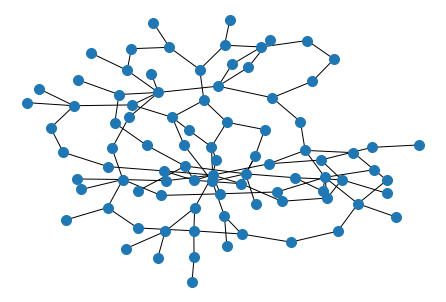

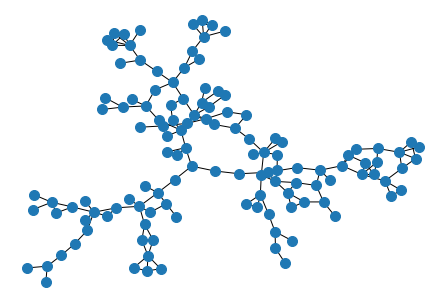

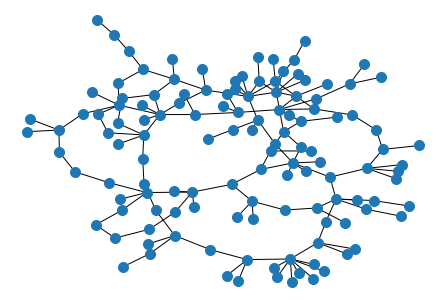

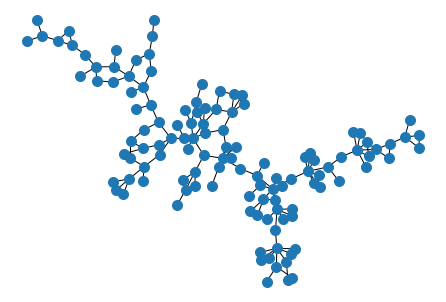

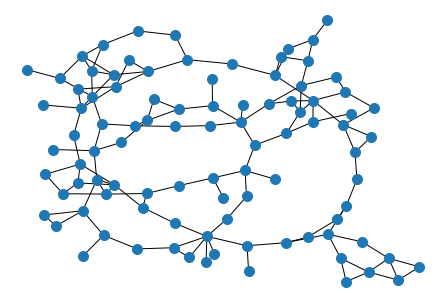

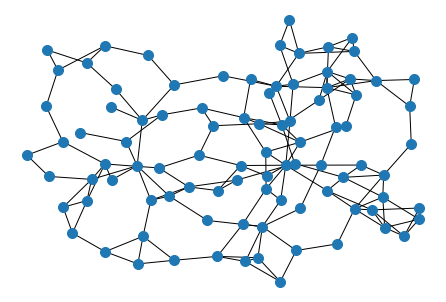

In [16]:
warnings.filterwarnings('ignore')
G = G_list[1000]
visualize_graph(generate_data(G))
visualize_graph(generate_data(augment_graph(G)))
visualize_graph(generate_data(augment_graph(G)))
visualize_graph(generate_data(augment_graph(G)))
visualize_graph(generate_data(augment_graph(G)))
visualize_graph(generate_data(augment_graph(G)))

In [13]:
torch_geometric.utils.to_networkx(data_list[0], to_undirected=True)

In [24]:
G_list[0]

EdgeView([('n0', 'n9'), ('n0', 'n11'), ('n1', 'n9'), ('n1', 'n6'), ('n2', 'n9'), ('n3', 'n16'), ('n4', 'n12'), ('n4', 'n13'), ('n4', 'n14'), ('n4', 'n17'), ('n5', 'n13'), ('n5', 'n10'), ('n5', 'n15'), ('n6', 'n10'), ('n7', 'n10'), ('n8', 'n15'), ('n11', 'n16')])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


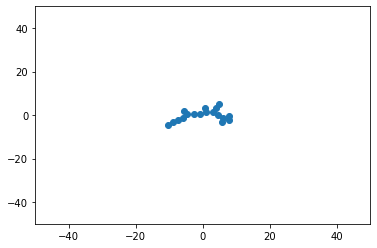

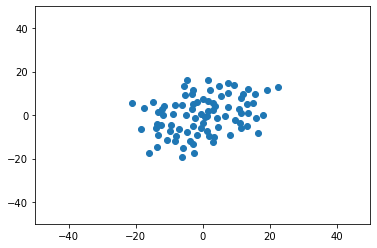

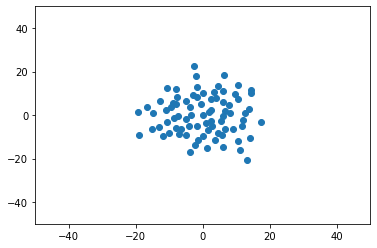

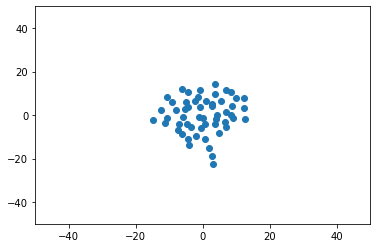

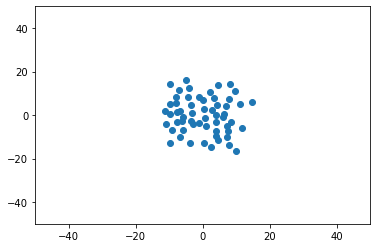

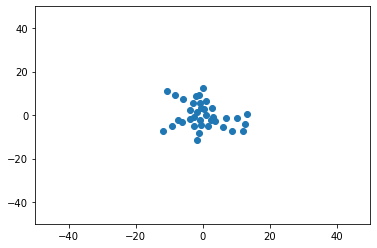

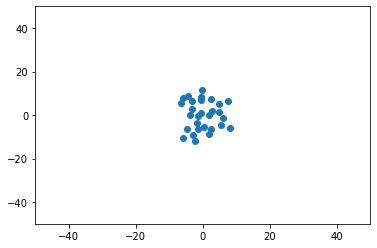

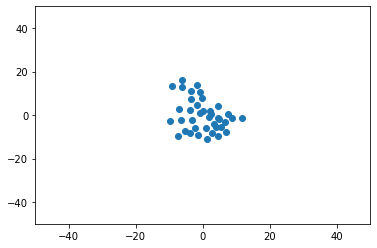

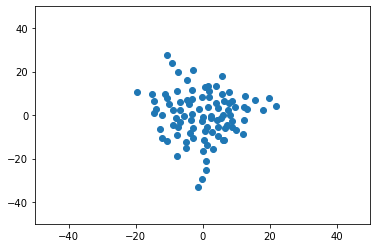

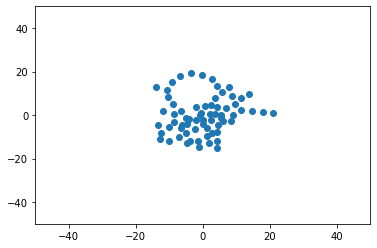

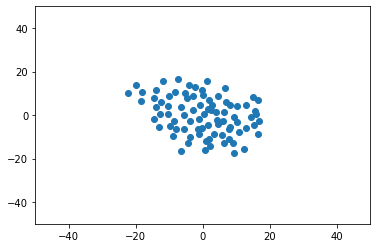

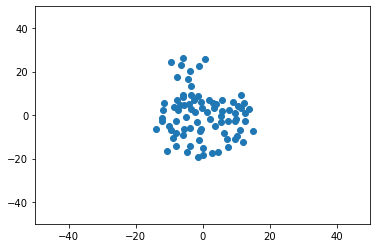

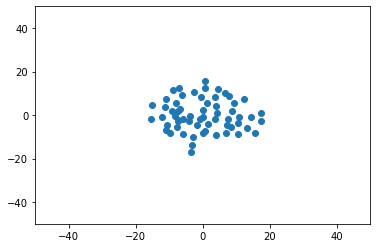

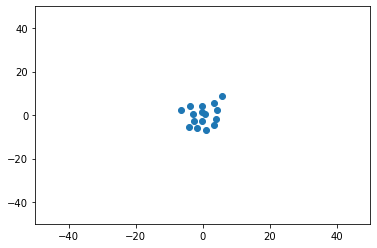

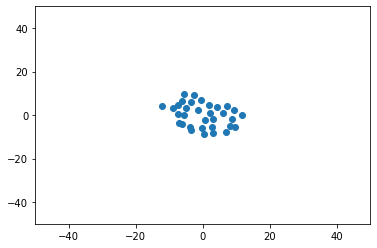

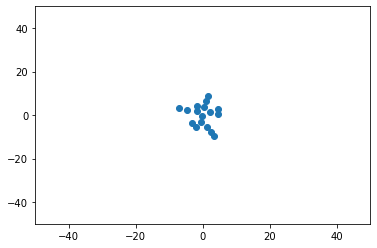

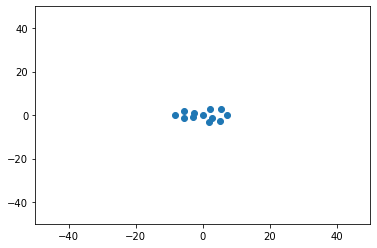

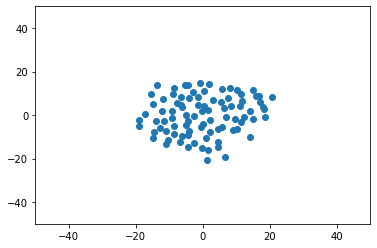

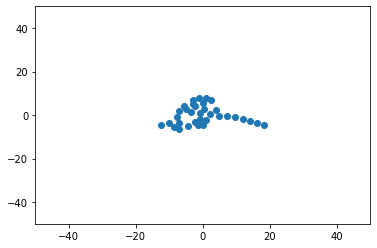

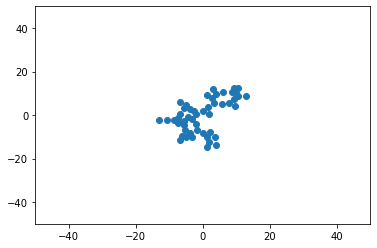

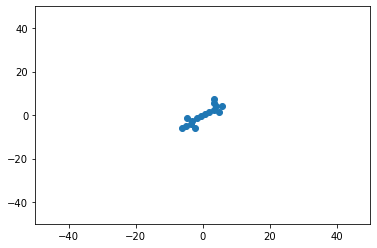

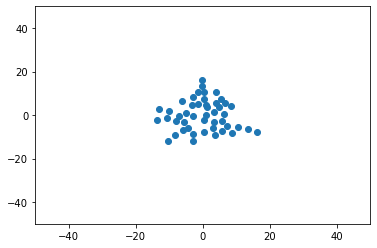

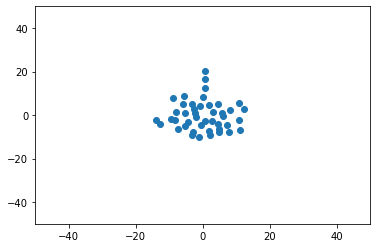

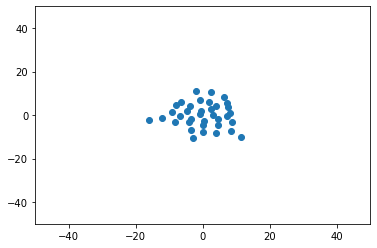

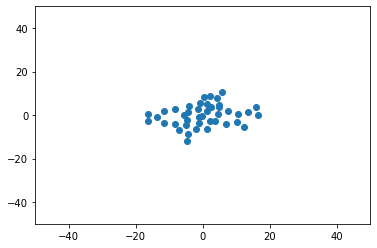

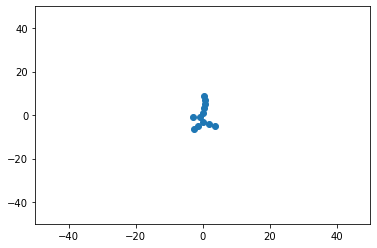

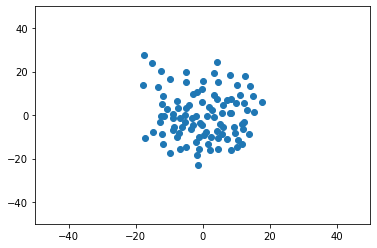

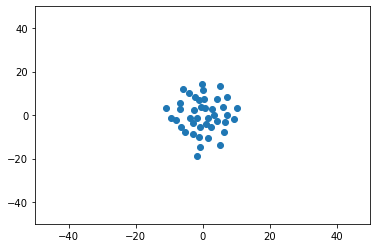

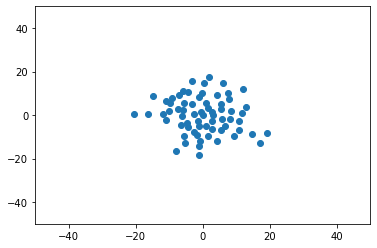

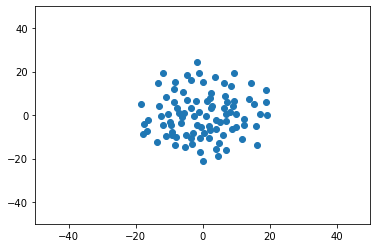

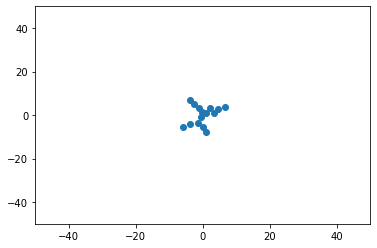

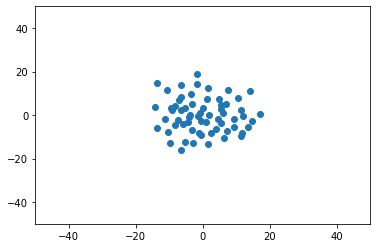

In [68]:
for i in range(32):
    p = data_list[i].pos
    x, y = p[:, 0], p[:, 1]

    lim = 50
    plt.figure()
    plt.scatter(x, y)
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)